In [1]:
import tensorflow as tf
import numpy as np
%config Completer.use_jedi = False

In [34]:
def data_pair_gen(max_len=10):
    """
    Generator that yields a random list of digits (0-9), a context (made of two digits) and a 
    vector that counts how often each digit occurs in the array.
    """
    while True:
        length = np.random.randint(1, max_len+1) # random length for output sequence
        x = np.random.randint(0, 10, length, dtype=np.int32) # random sequence of numbers
        context = np.random.randint(0, 10, 2, dtype=np.int32)# two context digits (which to count)
        y = np.array([np.count_nonzero(x == value) for value in context], dtype=np.int32) # counts
        
        yield tf.constant(x), tf.constant(context), tf.constant(y)
        
# for tf==2.4.0
# tf.data.Dataset.from_generator(generator=data_pair_gen,
#                                output_signature=(tf.TensorSpec(shape=(None,), dtype=tf.uint32),
#                                                  tf.TensorSpec(shape=(2,), dtype=tf.uint32),
#                                                  tf.TensorSpec(shape=(2,), dtype=tf.uint32))
#                               )

# for tf==2.2.0
ds = tf.data.Dataset.from_generator(generator=data_pair_gen,
                                    output_types=(tf.int32, tf.int32, tf.int32),
                                    output_shapes=((None,), (2,), (2,))
                                    )

(1,None, 30) for Input (one hot encoded sequence of digits)

(1, None, 2) for Output (output, categorical crossentropy)

# Weight matrices, their meaning and required dimensionality

X means element wise product.

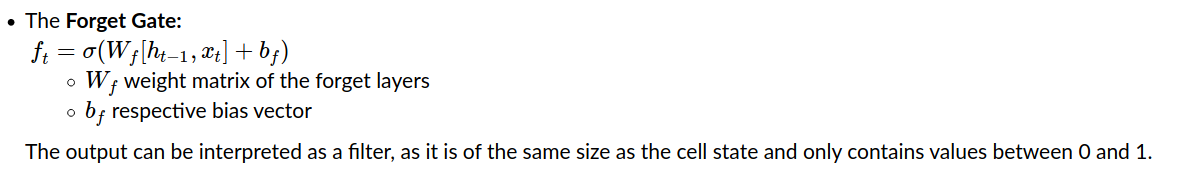


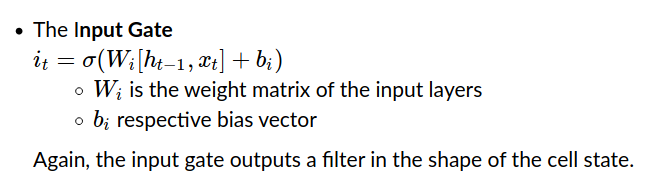

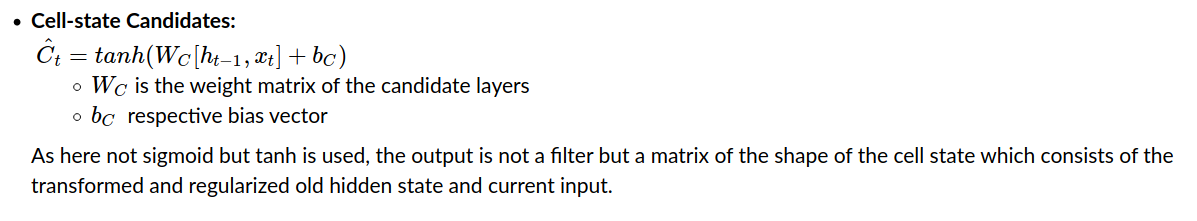

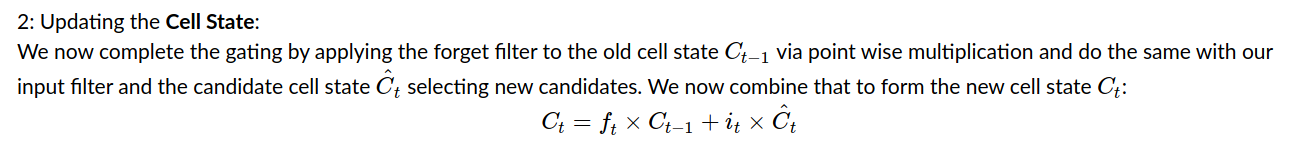

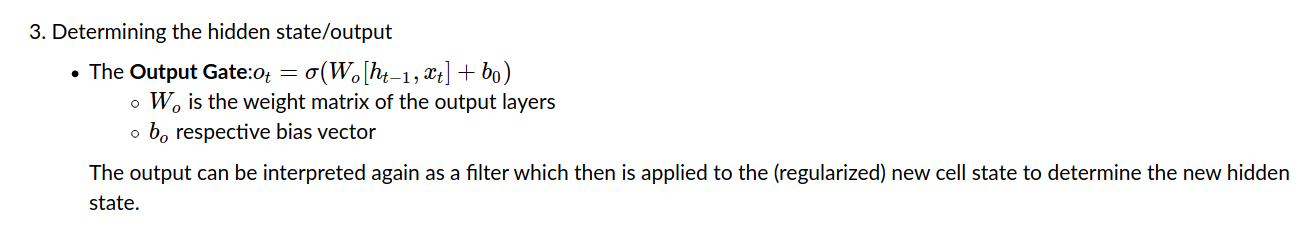

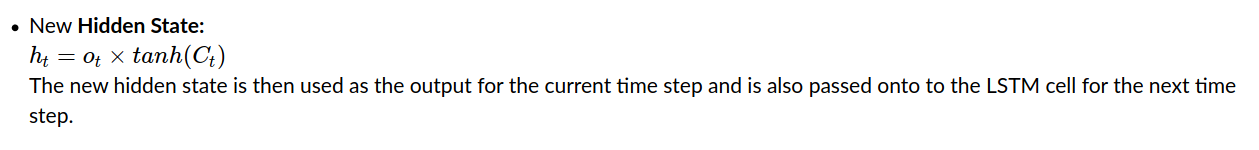

In [87]:
class LSTM_cell (tf.keras.layers.Layer):
    def __init__(self, hidden_dim = 100):
        super(LSTM_cell, self).__init__()
        
        #self.hidden_state = tf.zeros((10,1)) # don't store hidden and stell states in LSTM cell but rather outside
        #self.cell_state = tf.ones((10,1)) # pass cell and hidden state to the call function instead

    def build(self, input_shape=100):
        
        # weight matrices and bias vector shapes
        output_shape = (, hidden_dim)  # correct?
        weight_shape = (input_shape, input_shape+hidden_dim)  # correct?
        
        # input, concat shape
        
        # forget gate
        self.w_f = self.add_weight(shape= weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_f = self.add_weight(shape=output_shape,
                                   # bias of forget gate is initially 1
                                   initializer=tf.keras.initializers.Constant(value=1.0),
                                   trainable=True)
        # input gate
        self.w_i = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_i = self.add_weight(shape=output_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        # candidate layer
        self.w_c = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_c = self.add_weight(shape=output_shape, 
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        # output gate
        self.w_o = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_o = self.add_weight(shape=output_shape, 
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
    def call(self, x_t, h_t, C_t):
        
        # concatenate previous hidden_state and current input (shape is 20,1)
        concat = tf.concat([self.hidden_state, x_t], axis=1) # across axis with size 30 for input!
        
        # calculate f_t (the forget gate)
        f_t = tf.nn.sigmoid( tf.linalg.matmul(self.w_f, concat) + self.b_f )   # weight shapes must be 20 in second dimension, 
                                                                               # otherwise matmul does not work
        # calculate the input gate i_t
        i_t = tf.nn.sigmoid( tf.linalg.matmul(self.w_i, concat) + self.b_i )
        
        # calculate the Cell state candidates (C_hat)
        C_hat_t = tf.nn.tanh( tf.linalg.matmul(self.w_c, concat) + self.b_c )
        
        # calculate the Cell state (C_t)
        C_t = f_t * self.cell_state + i_t * C_hat_t
        
        # calculate the output state (o_t)
        o_t = tf.nn.sigmoid(tf.linalg.matmul(self.w_o, concat) + self.b_o )
        
        # calculate the new hidden state (h_t)
        h_t = o_t * tf.nn.tanh(C_t)
        
        return h_t, C_t

In [113]:
A= tf.TensorArray(dtype= tf.float32, size = 2)

b = tf.constant(10,dtype= tf.float32)

A.write(1, b)
A.read(1)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/mp/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,  File "/home/mp/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):  File "/home/mp/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)  File "<ipython-input-113-050f0131e66d>", line 5, in <module>
    A.write(1, b)  File "/home/mp/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 235, in wrapped
    ret

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [91]:
class LSTM_net (tf.keras.Model):
    '''
    Build a LSTM net with a single recurrent node
    '''
    def __init__(self):
        super(LSTM_net, self).__init__()
        
        self.hidden_dim = 100
        
        
        self.embedding = tf.keras.layers.Dense(100)
        self.recurrent = LSTM_cell(hidden_dim = hidden_dim)
        
        
        self.dense = tf.keras.layers.Dense(2, activation = "sigmoid")
        
        # define hidden and cell state inside LSTM net instead of LSTM Cell, pass as argument in call
        self.hidden_state = tf.Variable(tf.zeros(self.hidden_dim), trainable=False)
        self.cell_state = tf.Variable(tf.ones(hidden_dim),trainable = False)
        
        tf.outputs = tf.TensorArray(dtype = tf.float32, dynamic_size=True, )
    
        
        
    @tf.function
    def call(self, x):
        # assuming x is one hot encoded and has shape (None, 30, None) (first None -> batch size, second None -> Sequence length)
        
        # reset hidden and cell state before each call
        self.hidden_state.assign( tf.zeros(self.hidden_dim) )
        self.cell_state.assign( tf.ones(self.hidden_dim) )
        
        for digit in x:

            #embedding layer (maybe do it outside the loop for the entire x?)
            digit = self.embedding(digit)

            # update hidden state and cell
            self.hidden_state, self.cell_state = self.recurrent( digit, self.hidden_state, self.cell_state )
            
            self.dense(self.hidden_state)


        # apply dense layer without activation to get a larger number
        # = self.dense(hidden_state)

        return x

In [92]:
### BEFORE TRAINING: BUILD MODEL AND RUN TEST PREDICTION
lstm = LSTM_net()
for digits, context, true_vals in ds.take(1):
    res = lstm(digits)

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: while:3

In [83]:
res

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.49552608,  0.24585676,  0.17124408, -0.3229013 ,  0.28628552,
        -0.30592752, -0.11829492, -0.36112183, -0.34372222,  0.24073032]],
      dtype=float32)>